# The FIRS Level-1 and 1.5 data product

FIRS is a slit spectropolarimeter at the DST. It rasters a slit across the solar surface, and gets a spectrum in Stokes I, Q, U, and V as it does so, allowing for measurements of temperature, velocity, and the magnetic field. Currently, it is operated on the He I 10830 Angstrom line, which is formed in the upper chromosphere. The spectral window used by FIRS also contains the Si I 10827 Angstrom line, which is formed in the photosphere. Together, these lines can be used to get atmospheric parameters at two different formation environments simultaneously.

## Level-1

The Level-1 FIRS data product is a legacy data product. It is the result of the legacy firs_soft IDL package. This package corrects for instrumental effect, including:
- Dark current
- Solar (and optionally lamp) flat fields
- Optical train and telescope polarization
- I->QUV crosstalk
The code outputs the corrected data in binary format (the ".dat" file), which is not easily readable without dimensional information contained in the accompanying IDL metadata save file (".dat.sav"). 

## Level-1.5

At present, the Level-1.5 code further processes the results of the Level-1 code (until I get around to writing the polarization solver in python). It corrects for additional instrumental effects, and does some nice packaging to make the result more user-friendly in a code-agnostic environment (i.e., it outputs a FITS file instead of .sav or .npy or .pkl). It performs the following corrections:
- Wavelength calibration to the FTS atlas. This is *not* an absolute wavelength correction, but fairly typical in solar data products.
- Fringe correction for Stokes-QUV data, and prefilter correction for Stokes-I data
- Attempts a correction for V->Q,U crosstalk (based on solar features, so it is not applied in low-signal maps)
- Basic analysis for velocities and polarization degree (saved in a separate file)

We'll walk you through opening and using both Level-1 and 1.5. 

**Caution:** FIRS level-1 data in particular is deprecated in part due to the fact that the entire 4D data cube must be read in to memory as one object. If your machine has a small amount of RAM, consider skipping to Level-1.5

In [1]:
# Set up some basic imports
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits

# Also need ability to read IDL .sav files
from scipy.io import readsav

# And a way to download data
import requests

# Downloading data
Downloading can be done using wget. In python, we're going to use the requests package to grab some known files from the server. Take a look at the daily overview page to get a sense of what sort of data we'll be downloading:
[Daily Overview](http://ssoc.nmsu.edu/solardata/2024/05/01/)

## Note that these next two cells will download approximately 4.5 GiB to your current working directory.

In [3]:
# Download data (WILL take some time):
# Data file:
l1file = "http://ssoc.nmsu.edu/solardata/2024/05/01/level1/firs/firs.2.20240501.133627.reduced.dat"
# Metadata file:
l1savfile = "http://ssoc.nmsu.edu/solardata/2024/05/01/level1/firs/firs.2.20240501.133627.reduced.dat.sav"

# Save it to the current directory with the same filename as on the server
r = requests.get(l1file)
with open(l1file.split("/")[-1], 'wb') as f:
    f.write(r.content)
    
r = requests.get(l1savfile)
with open(l1savfile.split("/")[-1], 'wb') as f:
    f.write(r.content)

In [4]:
# Level-1.5 fits file
l15file = "http://ssoc.nmsu.edu/solardata/2024/05/01/level1/firs/firs_20240501_133627_l1.5.fits"
# Derived parameter map file:
l15mapfile = "http://ssoc.nmsu.edu/solardata/2024/05/01/level1/firs/firs_20240501_133627_l1.5_derived_parameter_maps.fits"

r = requests.get(l15file)
with open(l15file.split("/")[-1], 'wb') as f:
    f.write(r.content)
    
r = requests.get(l1savfile)
with open(l15mapfile.split("/")[-1], 'wb') as f:
    f.write(r.content)

# Okay, now we've got some data. We saved it to our current working directory.
For unix-like systems only, we can "ls" from Jupyter

In [10]:
ls *.dat*

firs.2.20240501.133627.reduced.dat  firs.2.20240501.133627.reduced.dat.sav


In [11]:
ls *.fits

firs_20240501_133627_l1.5_derived_parameter_maps.fits
firs_20240501_133627_l1.5.fits


## Level-1
We're going to start with opening the .sav file to get an idea of what we'll need to format the .dat file. If you have my [firs-tools package](https://github.com/sgsellers/firs-tools) in your $PYTHONPATH, you can use firs_tools.read_firs("fname.dat") to just read the data, but we'll go through this exhaustively as well.

In [12]:
savfile = l1savfile.split("/")[-1]
fsav = readsav(savfile)
fsav.keys()

dict_keys(['ic', 'totq', 'totu', 'totv', 'sshifts', 'llinepos', 'pos_solar', 'dx_final', 'dy_final', 'n_slits', 'int_only', 'ccont_wl', 'ii2q', 'ii2u', 'ii2v', 'ttime', 'ttel_azimuth', 'ttel_elevation', 'ttable_angle'])

### Contents:
- **ic:** Map containing continuum intensity
- **totq/u/v:** Map of Stokes-Q/U/V
- **sshifts, llinepos:** Vestigial keyworks from old versions of the pipeline
- **pos_solar:** Positions of lines used in form the IQUV maps
- **dx_final, dy_final, n_slits:** Number of data points in X, Y, and number of slits used in making the map. **These are the important parameters for reading the .dat map**.
- **int_only:** 1 if the instrument only measured Stokes-I.
- **ccont_wl:** Wavelength region used for calculating Stokes I->QUV crosstalk
- **ii2q/u/v:** Crosstalk maps
- **ttime:** Timestamps for each slit position (in hours since midnight)
- **ttel_azimuth/elevation:** Az/El values for each slit position
- **ttable_angle:** Angle of DST Coude table at each slit position

The only ones we really need here are dx_final, dy_final, and n_slits, but we can take a look at the maps too, just to see what we're dealing with:

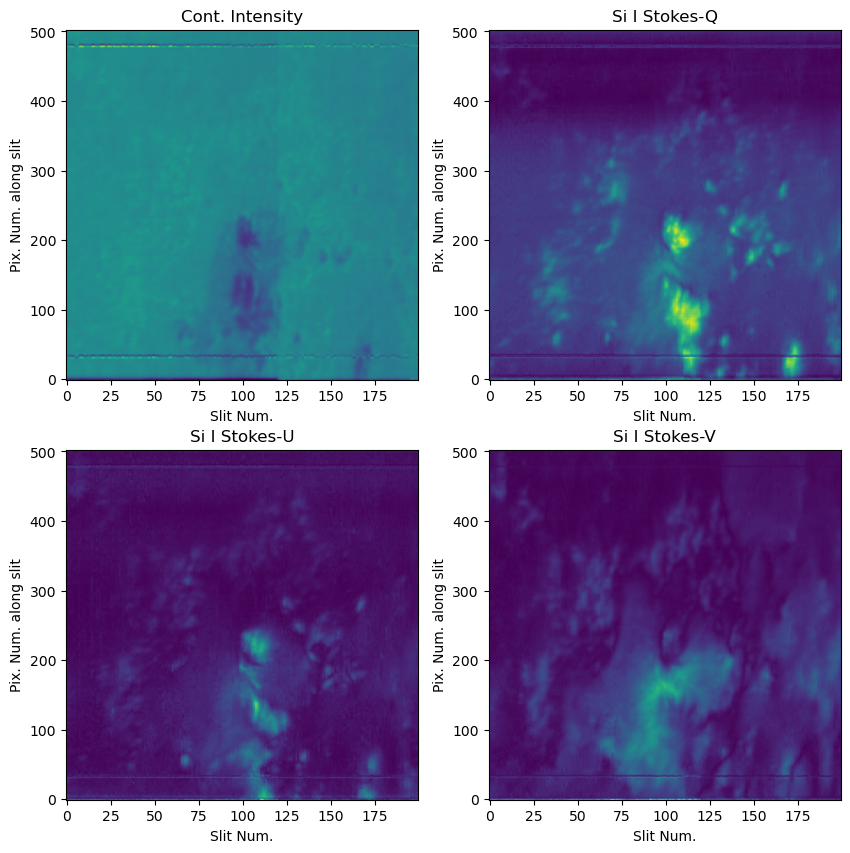

In [34]:
fig = plt.figure(figsize=(10,10))
ax_i = fig.add_subplot(221)
ax_i.imshow(fsav['ic'], origin='lower', aspect='auto')
ax_i.set_title("Cont. Intensity")
ax_i.set_ylabel("Pix. Num. along slit")
ax_i.set_xlabel("Slit Num.")
ax_q = fig.add_subplot(222)
ax_q.imshow(fsav['totq'], origin='lower', aspect='auto')
ax_q.set_title("Si I Stokes-Q")
ax_q.set_ylabel("Pix. Num. along slit")
ax_q.set_xlabel("Slit Num.")
ax_u = fig.add_subplot(223)
ax_u.imshow(fsav['totu'], origin='lower', aspect='auto')
ax_u.set_title("Si I Stokes-U")
ax_u.set_ylabel("Pix. Num. along slit")
ax_u.set_xlabel("Slit Num.")
ax_v = fig.add_subplot(224)
ax_v.imshow(fsav['totv'], origin='lower', aspect='auto')
ax_v.set_title("Si I Stokes-V")
ax_v.set_ylabel("Pix. Num. along slit")
ax_v.set_xlabel("Slit Num.")
plt.show()

### Look
It's a sunspot.

In [37]:
# Now to actually read the data. 
# We need to know the number of X/Y points
# Here, X is the wavelength axis. Y is the height of the beam.
# And how many slits the instrument used (usually 1)
print("Dx", fsav['dx_final'], "Dy", fsav['dy_final'], "Nslits", fsav['n_slits'])

datfile = l1file.split("/")[-1]

# Number of spectral points. +1 to deal with zero-based indexing
firs_nspex = int(fsav['dx_final'] + 1)
# Number of spatial points per slit
firs_ysize = int(fsav['dy_final'] + 1)
# Number of slits
firs_nslits = int(fsav['n_slits'])

# To get the last size element; the number of slit positions, 
# the best way is to read the data file. We can do this with
# numpy's "fromfile". The only thing we need to know to do this
# is the datatype. It's 32-bit floating point. This is the IDL
# default. Python uses 64-bit floats as default, so we do need
# to specify the dtype.
firs = np.fromfile(datfile, dtype=np.float32)
# This is unshaped. See?
print("Npoints", len(firs))

# Now we can figure out the number of slits, which we're going to recast as X.
# Factor of 4 is to deal with 4 Stokes parameters
firs_xsize = int(len(firs) / 4 / firs_nspex / firs_ysize / firs_nslits)

# And reshape the data file to some sensible object. Be careful of n_slits.
# You don't want a dangling 1-size axis.
if firs_nslits == 1:
    datacube = firs.reshape((firs_xsize, 4, firs_ysize, firs_nspex))
else:
    datacube = firs.reshape((firs_xsize, 4, firs_ysize, firs_nspex, firs_nslits))
datacube.shape

Dx 1018.0 Dy 502.0 Nslits 1
Npoints 410045600


(200, 4, 503, 1019)

### Again, really just download my firs-tools package. Or use Level-1.5.
Don't be a scientific masochist.

But now that we're in a sensible datacube, we can start working with our data! From the plots above, it looks slit position 100 passes over the sunspot. Let's take a look at it:

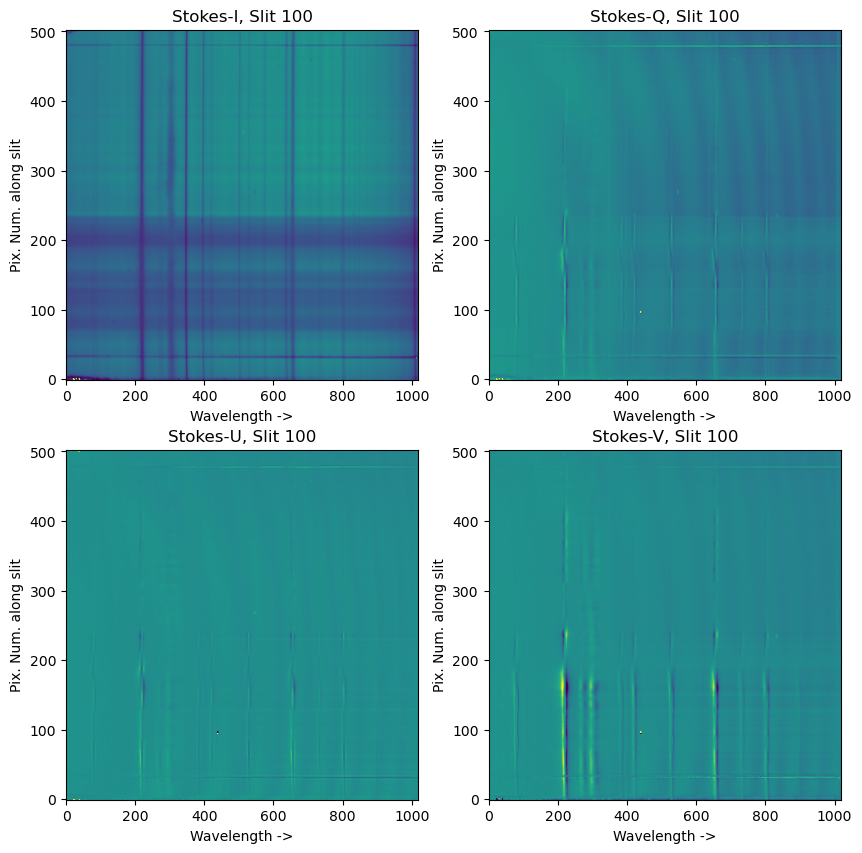

In [41]:
fig = plt.figure(figsize=(10,10))
ax_i = fig.add_subplot(221)
ax_i.imshow(datacube[100,0,:,:], origin='lower', aspect='auto', vmin=0, vmax=7500)
ax_i.set_title("Stokes-I, Slit 100")
ax_i.set_ylabel("Pix. Num. along slit")
ax_i.set_xlabel("Wavelength ->")
ax_q = fig.add_subplot(222)
ax_q.imshow(datacube[100,1,:,:], origin='lower', aspect='auto', vmin=-500, vmax=500)
ax_q.set_title("Stokes-Q, Slit 100")
ax_q.set_ylabel("Pix. Num. along slit")
ax_q.set_xlabel("Wavelength ->")
ax_u = fig.add_subplot(223)
ax_u.imshow(datacube[100,2,:,:], origin='lower', aspect='auto', vmin=-500, vmax=500)
ax_u.set_title("Stokes-U, Slit 100")
ax_u.set_ylabel("Pix. Num. along slit")
ax_u.set_xlabel("Wavelength ->")
ax_v = fig.add_subplot(224)
ax_v.imshow(datacube[100,3,:,:], origin='lower', aspect='auto', vmin=-500, vmax=500)
ax_v.set_title("Stokes-V, Slit 100")
ax_v.set_ylabel("Pix. Num. along slit")
ax_v.set_xlabel("Wavelength ->")
plt.show()

### That's a solar long-slit spectrum! 

The dark horizontal bands are the sunspot (except the extremely narrow ones at the top and bottom. Those are hairlines: fiducial marks used for alignment). The dark vertical bars are spectral lines. Specifically, the first major one on the left is Si I 1082.7 nm. The diffuse pair directly to the right of Si I, but before the next narrow dark line is He I 1082.9 and 1083.0 nm.

The curved, mostly-vertical bands on the QUV images are spectral fringes. These are induced by the LCVRs that modulate the polarimetry. The Level-1.5 pipeline corrects them under the assumption that they're time-invariant (which they are). Since they're time-invariant, a quick observer might wonder why they aren't flat-fielded out. The answer is inherent in the way solar spectrographs have to perform flat fields. Namely, on the Sun. Ask me about it some time.

Let's take a look at a single spectrum. Say, in a bright region adjacent to the sunspot. Like maybe index 175.

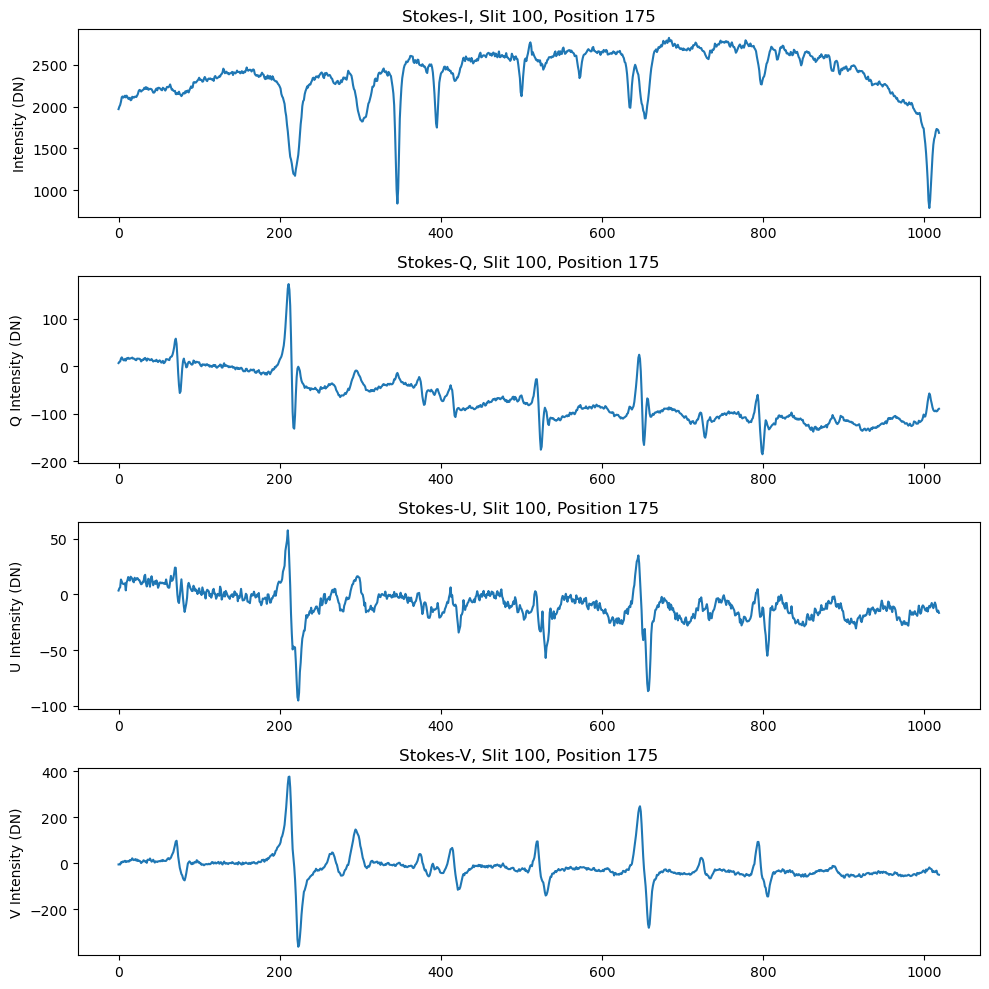

In [44]:
fig = plt.figure(figsize=(10,10))
ax_i = fig.add_subplot(411)
ax_i.plot(datacube[100,0,175,:])
ax_i.set_title("Stokes-I, Slit 100, Position 175")
ax_i.set_ylabel("Intensity (DN)")
ax_q = fig.add_subplot(412)
ax_q.plot(datacube[100,1,175,:])
ax_q.set_title("Stokes-Q, Slit 100, Position 175")
ax_q.set_ylabel("Q Intensity (DN)")
ax_u = fig.add_subplot(413)
ax_u.plot(datacube[100,2,175,:])
ax_u.set_title("Stokes-U, Slit 100, Position 175")
ax_u.set_ylabel("U Intensity (DN)")
ax_v = fig.add_subplot(414)
ax_v.plot(datacube[100,3,175,:])
ax_v.set_title("Stokes-V, Slit 100, Position 175")
ax_v.set_ylabel("V Intensity (DN)")
ax_v.set_xlabel("Wavelength ->")
plt.tight_layout()
plt.show()

### A couple things to note:
- In Stokes-I, there's a significant curvature of the spectrum as a function of wavelength
- The QUV signals should be centered around 0, but there's a significant linear tilt in Q, U
- The U signal in particular looks an awful lot like Stokes-V. This is indicative of crosstalk.
- The fringes are visible, particularly in Q, U. In fact, let's see what the top of the raster looks like, in quieter Sun, where the polarization signals are lower:

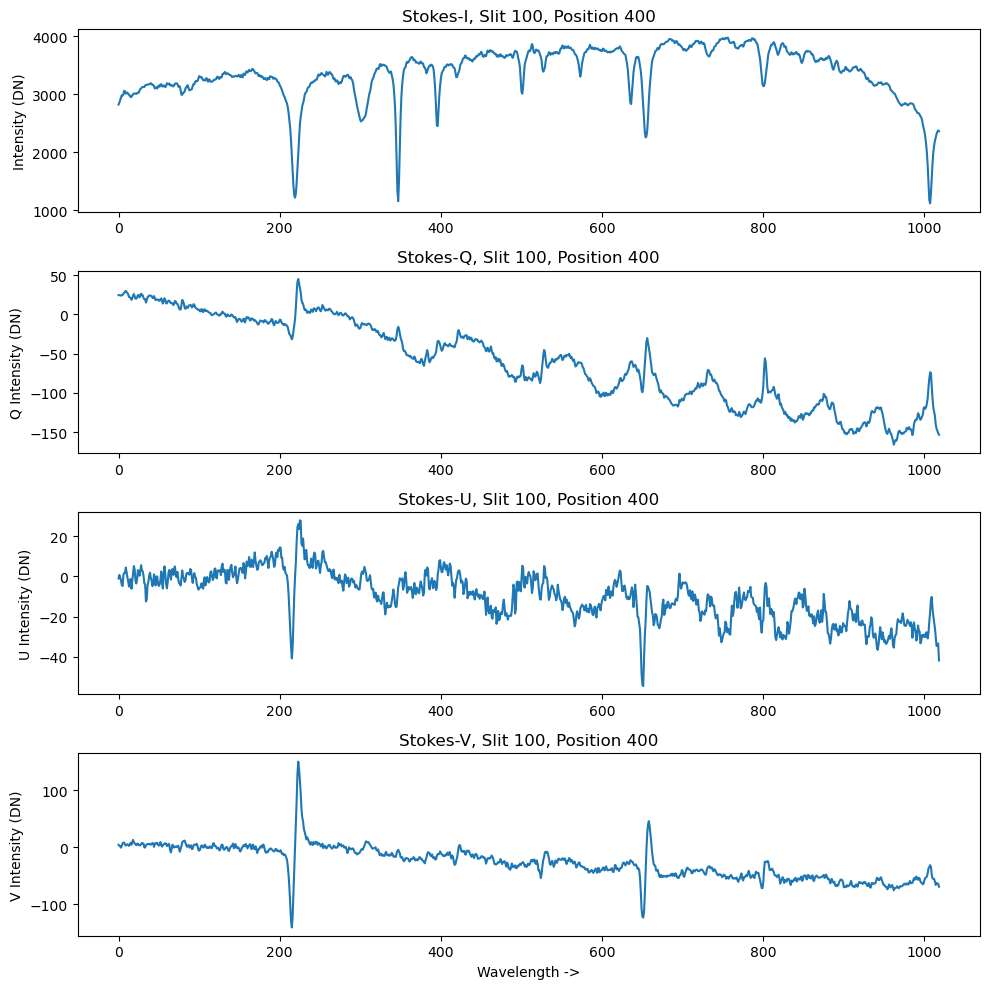

In [46]:
fig = plt.figure(figsize=(10,10))
ax_i = fig.add_subplot(411)
ax_i.plot(datacube[100,0,400,:])
ax_i.set_title("Stokes-I, Slit 100, Position 400")
ax_i.set_ylabel("Intensity (DN)")
ax_q = fig.add_subplot(412)
ax_q.plot(datacube[100,1,400,:])
ax_q.set_title("Stokes-Q, Slit 100, Position 400")
ax_q.set_ylabel("Q Intensity (DN)")
ax_u = fig.add_subplot(413)
ax_u.plot(datacube[100,2,400,:])
ax_u.set_title("Stokes-U, Slit 100, Position 400")
ax_u.set_ylabel("U Intensity (DN)")
ax_v = fig.add_subplot(414)
ax_v.plot(datacube[100,3,400,:])
ax_v.set_title("Stokes-V, Slit 100, Position 400")
ax_v.set_ylabel("V Intensity (DN)")
ax_v.set_xlabel("Wavelength ->")
plt.tight_layout()
plt.show()

### Now, you *could* spend a long time in Fourier space, trying to detrend those fringes using quiet sections of each slit image.

*Or* you could take a look at the Level-1.5 data product, where I did your job for you. You're welcome.

## FIRS Level-1.5:
These are FITS files. Let's open one, and take a look at its info:

In [47]:
l15fname = l15file.split("/")[-1]
l15 = fits.open(l15fname)
l15.info()

Filename: firs_20240501_133627_l1.5.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   ()      
  1  Stokes-I      1 ImageHDU        25   (1019, 200, 503)   float64   
  2  Stokes-Q      1 ImageHDU        25   (1019, 200, 503)   float64   
  3  Stokes-U      1 ImageHDU        25   (1019, 200, 503)   float64   
  4  Stokes-V      1 ImageHDU        25   (1019, 200, 503)   float64   
  5  lambda-coordinate    1 ImageHDU         9   (1019,)   float64   
  6  time-coordinate    1 ImageHDU         9   (200,)   float32   


#### Look! Each extension is labelled!
Each Stokes vector has its own extension too! So you don't have to read everything into memory!

There's an extension called "lambda-coordinate"! With a size equal to the number of wavelength points! I wonder what's in there!

And one called time-coordinate! With a size equal to the number of slit positions! Neat!

Let's check out the 0-extension header, see what's there for us:

In [48]:
l15[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2024-05-10T16:14:55' / File created                                  
ORIGIN  = 'NMSU/SSOC'                                                           
TELESCOP= 'DST     '                                                            
INSTRUME= 'FIRS    '                                                            
DATA_LEV=                  1.5                                                  
DATE_OBS= '2024-05-01T13:36:45.319'                                             
STARTOBS= '2024-05-01T13:36:45.319'                                             
DATE_END= '2024-05-01T14:37:38.317'                                             
ENDOBS  = '2024-05-01T14:37:

#### Aw man, information about pointing! And exposure times! And an origin! And timestamps! And a summary of processing steps!

Surely the rest of the file sucks though. What about "Stokes-I"?

In [49]:
l15['Stokes-I'].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 1019                                                  
NAXIS2  =                  200                                                  
NAXIS3  =                  503                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'Stokes-I'                                                            
CDELT1  =                  0.3 / arcsec                                         
CDELT2  =                 0.15 / arcsec                                         
CDELT3  =  0.03842524477659026 / Angstom                                        
CTYPE1  = 'HPLN-TAN'        

#### Nope! It's got WCS-standard coordinates! 

The 0th extension coordinates are human-readable. The data extension headers have coordinates that are compatible with high-level handlers, such as Sunpy's Map class.

Let's see the data:

In [50]:
l15['Stokes-I'].data.shape

(503, 200, 1019)

3D -- Y, X, lambda, note that the axes ARE different relative to the Level-1 file. This orientation aligns the data with the telescope optical axis.

Let's check slit number 100 in the new file:

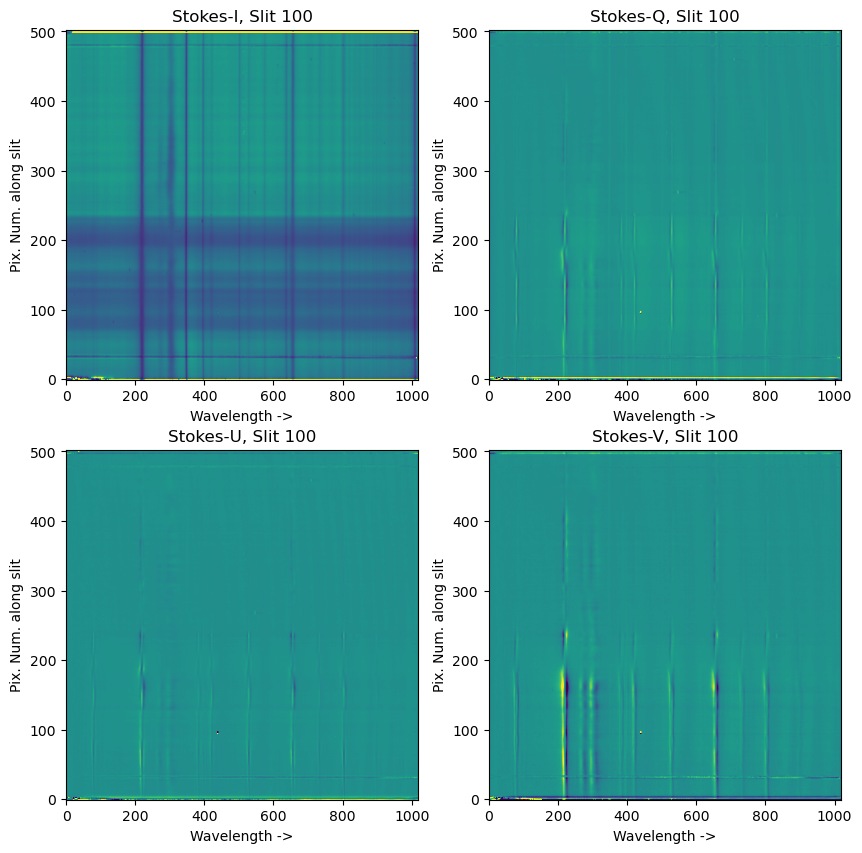

In [53]:
fig = plt.figure(figsize=(10,10))
ax_i = fig.add_subplot(221)
ax_i.imshow(l15['Stokes-I'].data[:,100,:], origin='lower', aspect='auto', vmin=0, vmax=7500)
ax_i.set_title("Stokes-I, Slit 100")
ax_i.set_ylabel("Pix. Num. along slit")
ax_i.set_xlabel("Wavelength ->")
ax_q = fig.add_subplot(222)
ax_q.imshow(l15['Stokes-Q'].data[:,100,:], origin='lower', aspect='auto', vmin=-500, vmax=500)
ax_q.set_title("Stokes-Q, Slit 100")
ax_q.set_ylabel("Pix. Num. along slit")
ax_q.set_xlabel("Wavelength ->")
ax_u = fig.add_subplot(223)
ax_u.imshow(l15['Stokes-U'].data[:,100,:], origin='lower', aspect='auto', vmin=-500, vmax=500)
ax_u.set_title("Stokes-U, Slit 100")
ax_u.set_ylabel("Pix. Num. along slit")
ax_u.set_xlabel("Wavelength ->")
ax_v = fig.add_subplot(224)
ax_v.imshow(l15['Stokes-V'].data[:,100,:], origin='lower', aspect='auto', vmin=-500, vmax=500)
ax_v.set_title("Stokes-V, Slit 100")
ax_v.set_ylabel("Pix. Num. along slit")
ax_v.set_xlabel("Wavelength ->")
plt.show()

The fringe pattern is still present, but less dominant than in the Level-1 file. The fringe correction works best around Si I 10827 and He I 10830, which is convenient, because that's the range that's actually important.

Now let's pull the wavelength information and take a look at the same spectra as before:

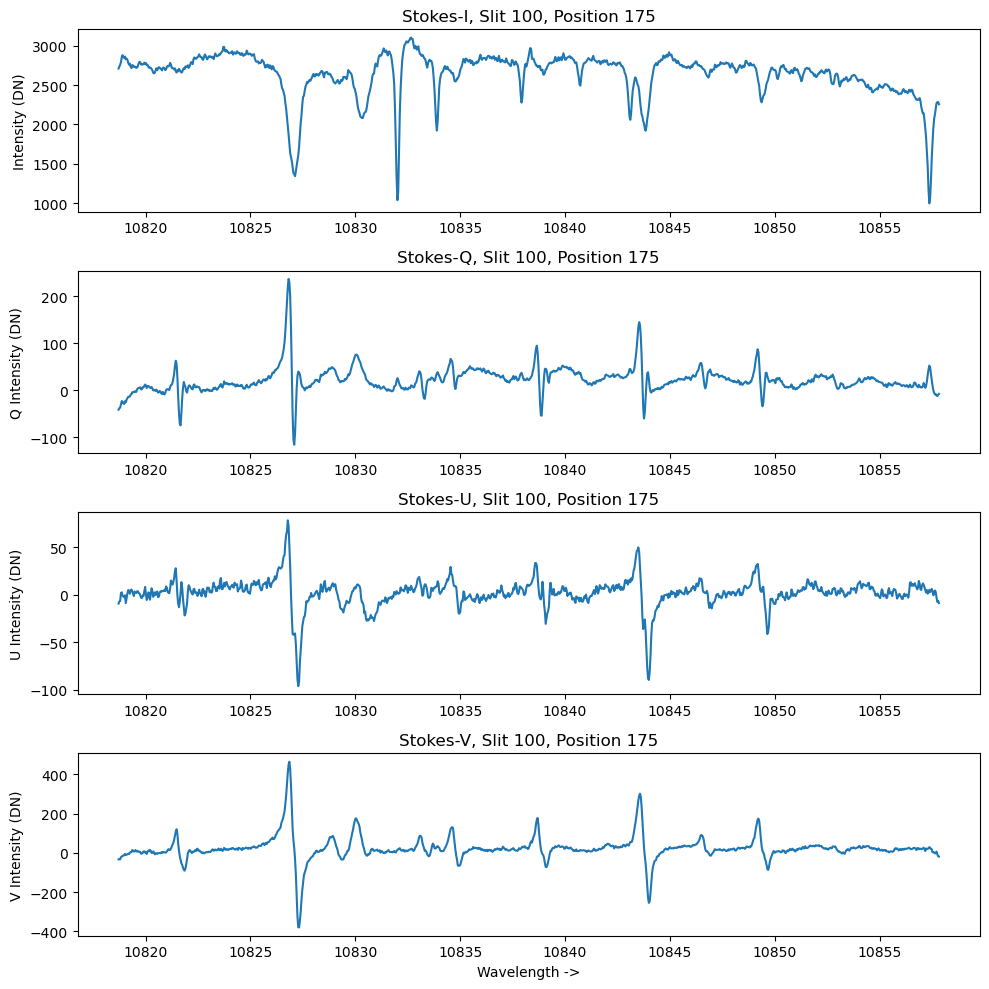

In [57]:
fig = plt.figure(figsize=(10,10))
ax_i = fig.add_subplot(411)
ax_i.plot(l15['lambda-coordinate'].data, l15['Stokes-I'].data[175,100,:])
ax_i.set_title("Stokes-I, Slit 100, Position 175")
ax_i.set_ylabel("Intensity (DN)")
ax_q = fig.add_subplot(412)
ax_q.plot(l15['lambda-coordinate'].data, l15['Stokes-Q'].data[175,100,:])
ax_q.set_title("Stokes-Q, Slit 100, Position 175")
ax_q.set_ylabel("Q Intensity (DN)")
ax_u = fig.add_subplot(413)
ax_u.plot(l15['lambda-coordinate'].data, l15['Stokes-U'].data[175,100,:])
ax_u.set_title("Stokes-U, Slit 100, Position 175")
ax_u.set_ylabel("U Intensity (DN)")
ax_v = fig.add_subplot(414)
ax_v.plot(l15['lambda-coordinate'].data, l15['Stokes-V'].data[175,100,:])
ax_v.set_title("Stokes-V, Slit 100, Position 175")
ax_v.set_ylabel("V Intensity (DN)")
ax_v.set_xlabel("Wavelength ->")
plt.tight_layout()
plt.show()

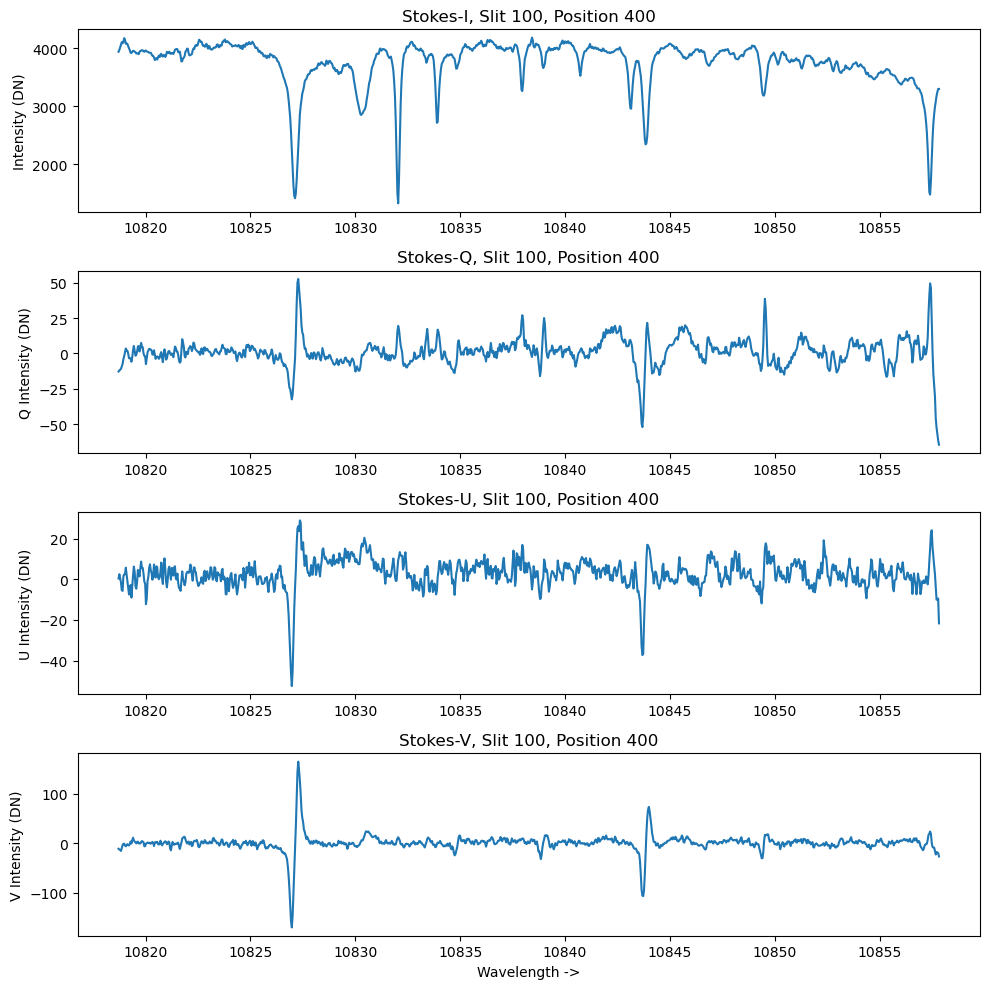

In [56]:
fig = plt.figure(figsize=(10,10))
ax_i = fig.add_subplot(411)
ax_i.plot(l15['lambda-coordinate'].data, l15['Stokes-I'].data[400,100,:])
ax_i.set_title("Stokes-I, Slit 100, Position 400")
ax_i.set_ylabel("Intensity (DN)")
ax_q = fig.add_subplot(412)
ax_q.plot(l15['lambda-coordinate'].data, l15['Stokes-Q'].data[400,100,:])
ax_q.set_title("Stokes-Q, Slit 100, Position 400")
ax_q.set_ylabel("Q Intensity (DN)")
ax_u = fig.add_subplot(413)
ax_u.plot(l15['lambda-coordinate'].data, l15['Stokes-U'].data[400,100,:])
ax_u.set_title("Stokes-U, Slit 100, Position 400")
ax_u.set_ylabel("U Intensity (DN)")
ax_v = fig.add_subplot(414)
ax_v.plot(l15['lambda-coordinate'].data, l15['Stokes-V'].data[400,100,:])
ax_v.set_title("Stokes-V, Slit 100, Position 400")
ax_v.set_ylabel("V Intensity (DN)")
ax_v.set_xlabel("Wavelength ->")
plt.tight_layout()
plt.show()

### This is still a bit messy, *but* it is better. Fringes are nearly-gone, curvature in Stokes-I is smaller, and the crosstalk signature is different.

Last thing, let's take a look at the derived parameter map file.